In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import time

import notebook_style
labels = notebook_style.labels

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1D-implicit-heat-transfer-coupled-with-cure-model" data-toc-modified-id="1D-implicit-heat-transfer-coupled-with-cure-model-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>1D implicit heat transfer coupled with cure model</a></span><ul class="toc-item"><li><span><a href="#Example:-Heat-transfer-steel-RTM-tool" data-toc-modified-id="Example:-Heat-transfer-steel-RTM-tool-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Example: Heat transfer steel RTM tool</a></span></li><li><span><a href="#Calculate-thermal-composite-properties" data-toc-modified-id="Calculate-thermal-composite-properties-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Calculate thermal composite properties</a></span></li><li><span><a href="#Cure-Model" data-toc-modified-id="Cure-Model-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Cure Model</a></span></li><li><span><a href="#Discretize-space" data-toc-modified-id="Discretize-space-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Discretize space</a></span></li><li><span><a href="#Time-discretization" data-toc-modified-id="Time-discretization-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>Time discretization</a></span></li><li><span><a href="#Implicit-Model-and-helper-funftions" data-toc-modified-id="Implicit-Model-and-helper-funftions-11.6"><span class="toc-item-num">11.6&nbsp;&nbsp;</span>Implicit Model and helper funftions</a></span></li><li><span><a href="#Simulate!" data-toc-modified-id="Simulate!-11.7"><span class="toc-item-num">11.7&nbsp;&nbsp;</span>Simulate!</a></span></li><li><span><a href="#Postprocessing" data-toc-modified-id="Postprocessing-11.8"><span class="toc-item-num">11.8&nbsp;&nbsp;</span>Postprocessing</a></span></li></ul></li></ul></div>

# 1D implicit heat transfer coupled with cure model

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2020_

    Code under MIT license, all other material under CC-BY-3.0 license

Just like in [lesson 07](./07%20-%201D%20Heat%20transfer%20coupled%20with%20cure%20model.ipynb) we couple the previously developed heat transfer solver (the implicit Crank-Nicholson-solver in this case) with the cure model from [lesson 01](./01%20-%20Cure%20Modell%20RTM6.ipynb). As we have seen we can use much larger time steps with the Crank-Nicholson-method while being stable and accurate. We also have to use a more precise method to calculate the degree of cure with these large time steps. We will use the Runge-Kutta-4-method from [lesson 02](./02%20-%20Numerical%20Integration%20of%20ODE.ipynb). 

## Example: Heat transfer steel RTM tool

<img src="./figures/heat 1d model 03.png" width="500"/>

The steel mold has the following properties:

- Thickness $d_{mold} = 20 mm$

- Density $\varrho_{steel} = 7850 \frac{kg}{m^3}$

- Specific heat capacity $c_{p, steel} = 465 \frac{J}{kg \cdot K}$

- Thermal conductivity $k_{steel} = 50 \frac{W}{m \cdot K}$

The composite part (fibers are perpendicular to heat transfer direction):

- Thickness $d_{comp} = 8 mm$

- Fiber volume fraction $\Phi = 0.6$

- Fibers (carbon): 

    - $\varrho_{f} = 1740 \frac{kg}{m^3}$

    - $c_{f} = 710 \frac{J}{kg \cdot K}$

    - $k_{f \perp} = 1.7 \frac{W}{m \cdot K}$

- Matrix (RTM6): 

    - $\varrho_{m} = 1110 \frac{kg}{m^3}$

    - $c_{m} = 1224 \frac{J}{kg \cdot K}$

    - $k_{f \perp} = 0.21 \frac{W}{m \cdot K}$

The cure model for RTM6 is the same as from lesson 01, with the reaction enthalpy: 

$H_r = 490 \cdot 10^3 \frac{J}{kg}$

For the model we will use a spatial discretization distance of: 

$\Delta x = 1 mm$

The total thickness is:

$d_{tot} = d_{mold} + \frac{d_{comp}}{2} = 24 mm$

## Calculate thermal composite properties

In [2]:
import material_data

### Mould material
# thermal steel properties
mould_material = material_data.steel
# use aluminium properties for comparison
# mould_material = material_data.aluminium


### Composite properties
# Fibre volume fraction
phi = .6

# Fibre material (carbon or glass)
fibre_material = material_data.CF
# fibre_material = material_data.GF

# Resin material (thermal properties, cure model selected later)
resin_material = material_data.EP

# Combine to composite material
composite_material = {**fibre_material, **resin_material}

### Calculate required thermal properties
composite_material = material_data.build_comp_material(composite_material, phi=phi)

for key in ["cp", "k_parallel", "k_perp", "psi"]:
    print(f"{key}: \t {composite_material[key]: .3f}")

cp: 	  865.885
k_parallel: 	  6.084
k_perp: 	  0.472
psi: 	  0.697


## Cure Model

In [3]:
import cure_calculation
from cure_models import Hein_2018 as cure_model

## Discretize space

Nx = 24


<IPython.core.display.Javascript object>


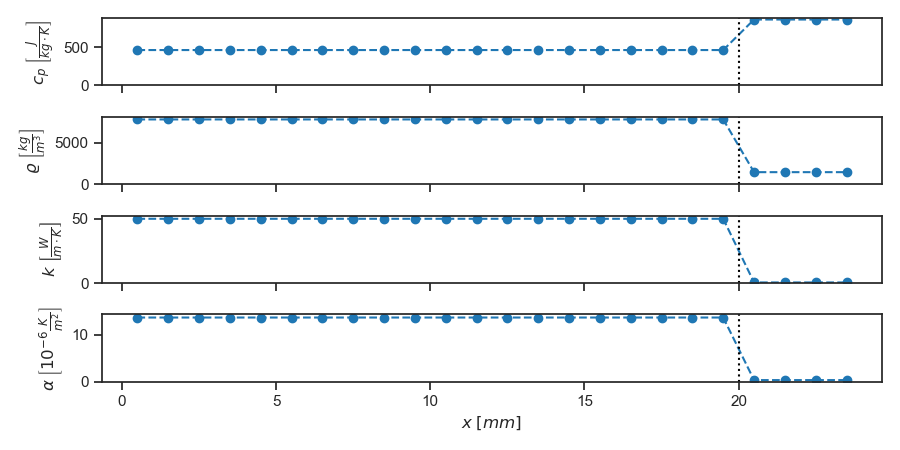

In [4]:
dx = 1/1000
d_mold = 20/1000
d_comp = 4/1000
Nx = int((d_mold + d_comp) / dx)
print("Nx =", Nx)

# shift coordinates half a step (element not material interface)
x = (np.arange(Nx) + .5) * dx  

# make indexes of materials (boolean arrays)
idx_mold = x <= d_mold
idx_comp = x > d_mold

# assign properties
cp = np.zeros(Nx)
cp[idx_mold] = mould_material.get("cp")
cp[idx_comp] = composite_material.get("cp")

rho = np.zeros(Nx)
rho[idx_mold] = mould_material.get("rho")
rho[idx_comp] = composite_material.get("rho")

k = np.zeros(Nx)
k[idx_mold] = mould_material.get("k")
k[idx_comp] = composite_material.get("k_perp")

alpha = material_data.calc_alpha(k, rho, cp)

# plot model properties
fig, ax = plt.subplots(4, 1, sharex=True)
ax1, ax2, ax3, ax4 = ax

line_kw = dict(marker="o", ls="--")
plt.sca(ax1)
plt.plot(x*1000, cp, **line_kw)
plt.ylabel(r"$c_p \; \left[ \frac{J}{kg \cdot K} \right]$")
plt.sca(ax2)
plt.plot(x*1000, rho, **line_kw)
plt.ylabel(r"$\varrho \; \left[ \frac{kg}{m^3} \right]$")
plt.sca(ax3)
plt.plot(x*1000, k, **line_kw)
plt.ylabel(r"$k \; \left[ \frac{W}{m \cdot K} \right]$")
plt.sca(ax4)
plt.plot(x*1000, alpha*1e6, **line_kw)
plt.ylabel(r"$\alpha \; \left[ 10^{-6} \frac{K}{m^2} \right]$")
plt.xlabel(r"$x \; [mm]$");

for _ax in ax:
    # plot mold - composite part - interface
    _ax.axvline(d_mold*1000, ls=":", color="k")
    _ax.set_ylim((0, None))
plt.tight_layout()

## Time discretization

limit for numerical stability: dt = 0.0365025 s
used time step: dt = 0.58404 s
t_max = 18900.0 s = 315.0 min
Nt = 32361


<IPython.core.display.Javascript object>


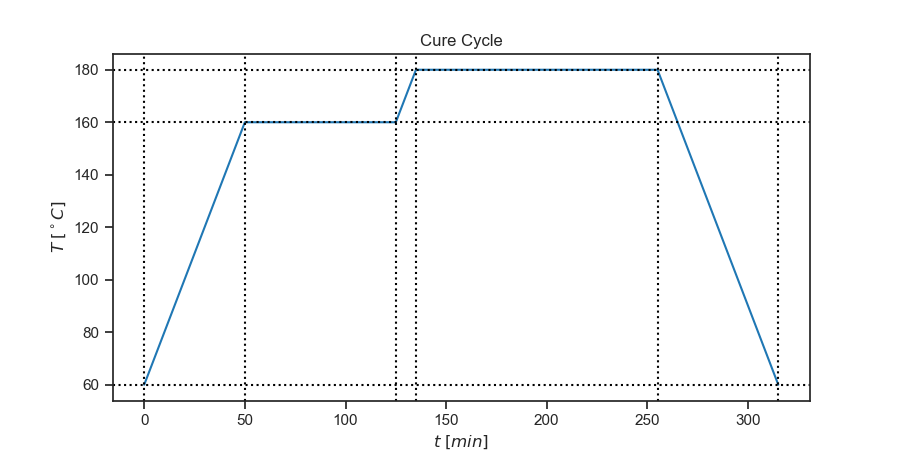

In [11]:
from helpers import add_process_step

# CFL criterion
dt = dx**2 / np.max(alpha) / 2
print(f"limit for numerical stability: dt = {dt} s")
dt *= 16
print(f"used time step: dt = {dt} s")

## Temperature cycle
# ramp [K/min]
ramp = 2

# start and end temperature [°C]
temp0 = 60
cycle = np.array([[0, temp0]])

# first dwell temperature and dwell duration [min]
temp1 = 160
duration1 = 75
cycle = add_process_step(cycle, temp1, duration1, ramp=ramp)

# second dwell temperature and duration
temp2 = 180
duration2 = 120
cycle = add_process_step(cycle, temp2, duration2, ramp=ramp)

# cool phase
cycle = add_process_step(cycle, temp0, duration=0, ramp=ramp)

# convert minutes to seconds
cycle[:, 0] *= 60

t_max = cycle[-1, 0]
print(f"t_max = {t_max} s = {t_max / 60} min")
Nt = int(t_max / dt + 1) 
print(f"Nt = {Nt}")
t = np.arange(Nt) * dt


plt.figure()
plt.title('Cure Cycle')
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1])
for _temp in np.unique(cycle[:, 1]):
    plt.axhline(_temp, ls=":", color="k")
for _t in np.unique(cycle[:, 0] / 60):
    plt.axvline(_t, ls=":", color="k")    

## Implicit Model and helper funftions

Use the same functions from previous lessons for Crank-Nicholson and Runge-Kutta methods. The latter we have to adapt to the cure calculation. 

In [6]:
def calc_A_matrix(sigma, Phi=.5):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    Nx = len(sigma)
    A_size = (Nx - 2)
    # Setup the diagonal of the operator.
    D = 2 + Phi * (sigma[:-2] + 2* sigma[1:-1] + sigma[2:])
    # Setup the Neumann condition for the last element.
    D[-1] -= Phi * (sigma[-2] + sigma[-1])
    # Setup the upper diagonal of the operator.
    U = -Phi * (sigma[1:-1] + sigma[2:])[:-1]
    # Setup the lower diagonal of the operator.
    L = -Phi * (sigma[:-2] + sigma[1:-1])[1:]
    # Assemble the operator.
    A = sparse.diags(diagonals=[D, U, L],
                 offsets=[0, 1, -1], shape=(A_size, A_size),
                 format="csr")
    return A
def calc_A2_matrix(sigma, Phi=.5):
    """
    Compute Matrix A2 for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    Nx = len(sigma)
    A_size = (Nx - 2)
    # Setup the diagonal of the operator.
    D = 2 + (Phi - 1) * (sigma[:-2] + 2* sigma[1:-1] + sigma[2:])
    # Setup the Neumann condition for the last element.
    D[-1] -= (Phi - 1) * (sigma[-2] + sigma[-1])
    # Setup the upper diagonal of the operator.
    U = (1 - Phi) * (sigma[1:-1] + sigma[2:])[:-1]
    # Setup the lower diagonal of the operator.
    L = (1 - Phi) * (sigma[:-2] + sigma[1:-1])[1:]
    # Assemble the operator.
    A2 = sparse.diags(diagonals=[D, U, L],
                 offsets=[0, 1, -1], shape=(A_size, A_size),
                 format="csr")
    return A2
def calc_b_vector(T, sigma, Phi=.5, T_left=None):
    """
    Compute vector b + b_bc for 1D model with dirichlet BC on left and 
    Neumann BC (heat flux udx) on right side
    """
    if T_left is None:
        T_left = T[0]
    b = np.zeros(len(T) - 2)
    # Set Dirichlet condition.
    b[0] += (Phi*T_left + (1-Phi) * T[0]) * (sigma[0] + sigma[1])
    return b
def crank_nicholson_1D_nofluxright(T, sigma, A, A2, Phi=.5, T_left=None):
    """
    Solve implicit matrix formulation, pass matrix A (only calculate once)
    """
    if T_left is None:
        T_left = T[0]
    # Generate the right-hand side of the system.
    b = A2.dot(T[1:-1]) + calc_b_vector(T, sigma, Phi, T_left)
    # Solve the system with scipy.linalg.solve.
    T[1:-1] = spsolve(A, b)
    # Apply the Neumann boundary condition.
    T[-1] = T[-2] 
    T[0] = T_left
    return T
def RK4_method(X0, dt, temp, cure_model):
    """Runge-Kutta-4-Method for cure model, return reaction rate dX/dT"""
    k1 = cure_calculation.reaction_model(X0, temp, cure_model)
    k2 = cure_calculation.reaction_model(X0 + k1 * dt/2, temp, cure_model)
    k3 = cure_calculation.reaction_model(X0 + k2 * dt/2, temp, cure_model)
    k4 = cure_calculation.reaction_model(X0 + k3 * dt, temp, cure_model)
    dXdt =(k1 + 2*k2 + 2*k3 + k4) / 6
    return dXdt

## Simulate!

i_snap = 107


<IPython.core.display.Javascript object>


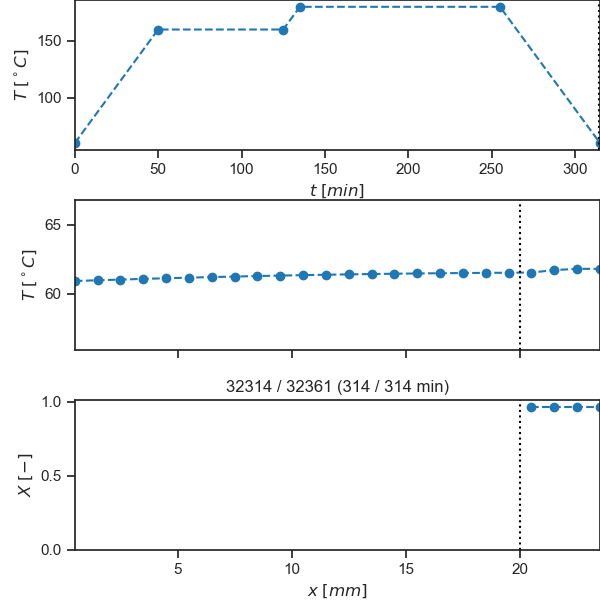

In [7]:
# Set initial conditions
T = np.zeros(Nx)
T[:] = cycle[0, 1]

# degree of cure
X = np.zeros(np.sum(idx_comp))

# choose how often to update plot
i_snap = Nt // 300
print("i_snap =", i_snap)

### prepare output arrays
# 1st column: max temp and X in composite
# 2nd column: min temp and X in composite
# 3rd column: temp and X at mold interface of composite
# 4th column: temp and X at middle of composite (border of simulation)
T_out = np.zeros((Nt, 4))
X_out = np.zeros((Nt, 4))

# prepare plot
fig, ax = plt.subplots(3, 1, figsize=[6, 6])
ax1, ax2, ax3 = ax

plt.sca(ax1)
plt.xlabel(r"$t \; [min]$")
plt.ylabel(r"$T \; [ ^\circ C ]$")
plt.plot(cycle[:, 0]/60, cycle[:, 1], **line_kw)
p_cycle = plt.axvline(cycle[0, 0]/60, ls=":", color="k")

plt.sca(ax2)
plt.ylabel(r"$T \; [ ^\circ C ]$")
p_temp, = plt.plot(x*1000, T, **line_kw)

plt.sca(ax3)
plt.ylabel(r"$X \; [ - ]$")
p_cure, = plt.plot(x[idx_comp]*1000, X, **line_kw)
plt.xlabel(r"$x \; [mm]$")

# plot mold - composite part - interface    
[_ax.axvline(d_mold*1000, ls=":", color="k") for _ax in ax[1:]]

[_ax.autoscale(axis="x", tight=True) for _ax in ax[:-1]]
ax3.set_xlim(ax2.get_xlim())
ax2.set_xticklabels([])

plt.tight_layout(pad=0)
plt.ion();

In [8]:
Phi = 1 / 2 # Crank-Nicholson-Method
sigma = alpha * dt / dx**2
A = calc_A_matrix(sigma, Phi=Phi)
A2 = calc_A2_matrix(sigma, Phi=Phi)

t_calc = 0
for n in range(Nt):
    t0 = time.time()
    # Left Boundary: set value from temperate cycle 
    T_left = cure_calculation.interpol_tempcycle(t[n], cycle)
    
    # calculate heat transfer
    T = crank_nicholson_1D_nofluxright(T, sigma, A, A2, Phi, T_left)
    
    # reaction rate
    dXdt = RK4_method(X, dt, T[idx_comp], cure_model)
    # update degree of cure
    X += dXdt*dt

    # released heat
    q = dXdt * dt * cure_model["Hr"] * (1-composite_material["psi"])    
    T[idx_comp] += q / cp[idx_comp]
    
    # right boundary condition (no heat flux)
    T[-1] = T[-2]
    # left boundary condition 
    T[0] = T_left
    
    t_calc += time.time() - t0
    
    # write output
    T_out[n, 0] = T[idx_comp].max()
    T_out[n, 1] = T[idx_comp].min()
    T_out[n, 2] = T[idx_comp][0]
    T_out[n, 3] = T[idx_comp][-1]
    X_out[n, 0] = X.max()
    X_out[n, 1] = X.min()
    X_out[n, 2] = X[0]
    X_out[n, 3] = X[-1]    
    
    # update plot
    if n % i_snap == 0:
        ax3.set_title("%d / %d (%d / %d min)" %(n, Nt, t[n]/60, t[-1]/60))
        p_cycle.set_xdata(t[n]/60)
        p_temp.set_ydata(T)
        p_cure.set_ydata(X)      
        ax2.set_ylim((T.min()-5, T.max()+5))
        ax3.set_ylim((0, X.max()+.05))
        fig.canvas.draw()

print(f"elapsed time for calculation = {t_calc: .3f} s")
print(f"number of iterations = {Nt}")
print(f"-> {Nt / t_calc: .3f} iterations / s")

elapsed time for calculation =  8.799 s
number of iterations = 32361
->  3677.738 iterations / s


## Postprocessing

T_max =  180.22


<IPython.core.display.Javascript object>


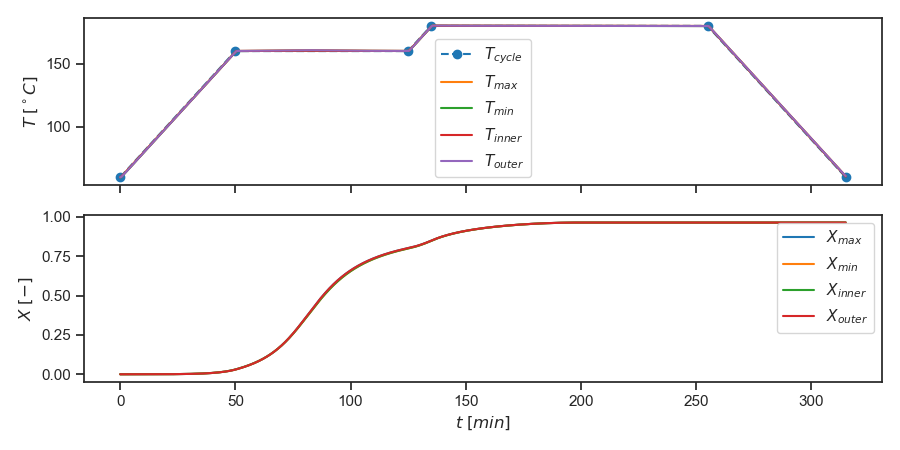

In [9]:
print(f"T_max = {T_out[:, 0].max(): .2f}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax1, ax2 = ax
ax1.plot(cycle[:, 0]/60, cycle[:, 1], "o--", label=r"$T_{cycle}$")

for i, _label in enumerate(["max", "min", "inner", "outer"]):
    plt.sca(ax1)
    label = r"$T_{%s}$" %_label
    plt.plot(t/60, T_out[:, i], label=label)
    plt.sca(ax2)
    label = r"$X_{%s}$" %_label
    plt.plot(t/60, X_out[:, i], label=label)

for _ax in ax:
    _ax.legend()

ax1.set_ylabel(r"$T \; [ ^\circ C ]$")
ax2.set_ylabel(r"$X \; [ - ]$")
ax2.set_xlabel(r"$t \; [min]$")
plt.tight_layout();